# Lesson 5 solutions: Histograms and Monte Carlo on GPUs

In [1]:
import math
import copy

import h5py
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba as nb
import numba.cuda

import uproot
import awkward as ak
from hist import Hist

<br><br><br>

## Exercise 1: make a CUDA kernel with Numba

In [2]:
dataset_hdf5 = h5py.File("data/SMHiggsToZZTo4L.h5")
e1_pt = cp.asarray(dataset_hdf5["ee_mumu"]["e1"]["pt"])
e1_phi = cp.asarray(dataset_hdf5["ee_mumu"]["e1"]["phi"])
e1_eta = cp.asarray(dataset_hdf5["ee_mumu"]["e1"]["eta"])
e2_pt = cp.asarray(dataset_hdf5["ee_mumu"]["e2"]["pt"])
e2_phi = cp.asarray(dataset_hdf5["ee_mumu"]["e2"]["phi"])
e2_eta = cp.asarray(dataset_hdf5["ee_mumu"]["e2"]["eta"])

In [3]:
@nb.cuda.jit
def compute_z_mass(e1_pt, e1_phi, e1_eta, e2_pt, e2_phi, e2_eta, z_mass):
    i = nb.cuda.grid(1)
    if i < len(z_mass):
        z_mass[i] = math.sqrt(
            2*e1_pt[i]*e2_pt[i] * (math.cosh(e1_eta[i] - e2_eta[i]) - math.cos(e1_phi[i] - e2_phi[i]))
        )

In [4]:
z_mass = cp.empty_like(e1_pt)

threads_per_block = 1024
blocks_per_grid = int(np.ceil(len(z_mass) / 1024))

compute_z_mass[blocks_per_grid, threads_per_block](e1_pt, e1_phi, e1_eta, e2_pt, e2_phi, e2_eta, z_mass)

/home/jpivarski/miniforge3/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 31 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


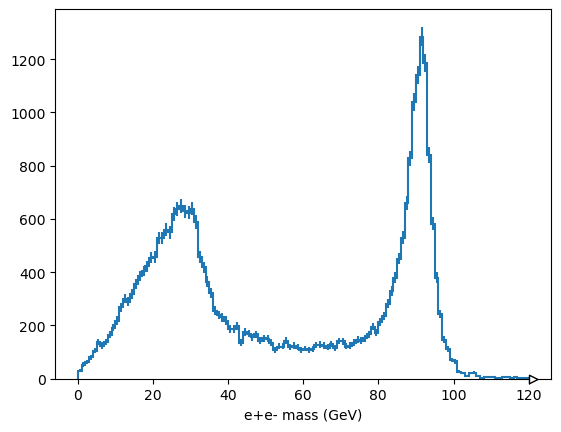

In [5]:
fig, ax = plt.subplots()

Hist.new.Reg(120, 0, 120, name="e+e- mass (GeV)").Double().fill(z_mass.get()).plot()

None

<br><br><br>

## Exercise 2: fill a histogram on the GPU

In [6]:
with uproot.open("data/dimuon_mass.root:tree/mass") as branch:
    dimuon_mass = cp.asarray(branch.array(library="np"))

In [7]:
bin_values = cp.zeros(1200, dtype=cp.uint32)

In [8]:
@nb.cuda.jit(device=True)
def bin_index(mass):
    if mass < 0:
        return 0
    elif mass >= 120:
        return 1199
    else:
        return mass * 10

@nb.cuda.jit
def fill_histogram(bin_values, dimuon_mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(dimuon_mass):
        nb.cuda.atomic.inc(bin_values, bin_index(dimuon_mass[thread_idx]), -1)

threads_per_block = 1024
blocks_per_grid = int(np.ceil(len(dimuon_mass) / 1024))

bin_values = cp.zeros(1200, dtype=np.uint32)

fill_histogram[blocks_per_grid, threads_per_block](bin_values, dimuon_mass)

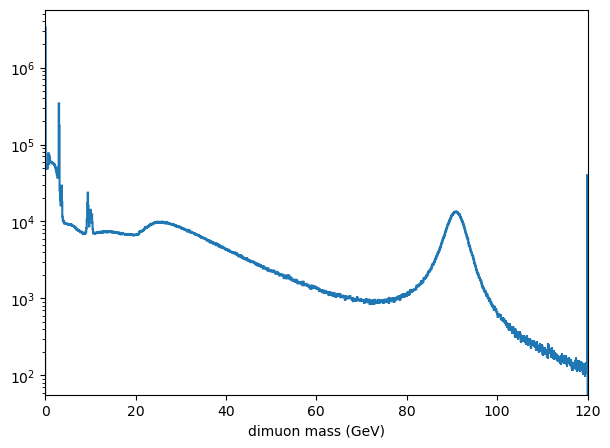

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

h = Hist.new.Reg(1200, 0, 120, label="dimuon mass (GeV)").Double()
h.values()[:] = bin_values.get()
h.plot(ax=ax)

ax.set_xlim(0, 120)
ax.set_yscale("log")

None

<br><br><br>

## Exercise 3: use Monte Carlo to calculate π

In [10]:
from numba.cuda.random import create_xoroshiro128p_states
from numba.cuda.random import xoroshiro128p_uniform_float32

### Initial exploration

If we try to jump directly to the solution, the final area estimate, we're likely to make a mistake and get something like zero or an area that does not converge as the number of samples increases. (_I_ am, anyway.) Usually, this is because of mistakes like cutting off the region of interest, getting $x$ and $y$ as the same value, or failing to fill the output buffer.

Most of these types of mistakes can be caught by looking at the random samples before attempting to compute an area, so let's start with that.

The first attempt should only fill an output array with $x$, $y$ pairs so that we can look at them and confirm that they look uniform on the range we expect.

In [11]:
@nb.cuda.jit
def fill_dots(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    outx[thread_idx] = x
    outy[thread_idx] = y

Since this is exploratory, use a very small number of points.

Run this a few times to see the random numbers change.

In [12]:
threads_per_block = 100
blocks_per_grid = 1

rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=12345)

outx = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)
outy = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)

fill_dots[blocks_per_grid, threads_per_block](rng_states, outx, outy)

/home/jpivarski/miniforge3/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


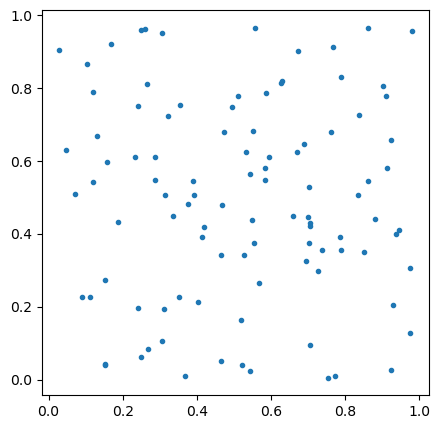

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(outx.get(), outy.get(), marker=".")

None

Now let's introduce the circle constraint.

In [14]:
@nb.cuda.jit
def fill_dots_circle(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)
    if x**2 + y**2 < 1:
        outx[thread_idx] = x
        outy[thread_idx] = y

With enough points, the cookie-cutter should carve out an obvious line.

In [15]:
threads_per_block = 1024
blocks_per_grid = 1

rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=12345)

outx = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)
outy = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)

fill_dots_circle[blocks_per_grid, threads_per_block](rng_states, outx, outy)

/home/jpivarski/miniforge3/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


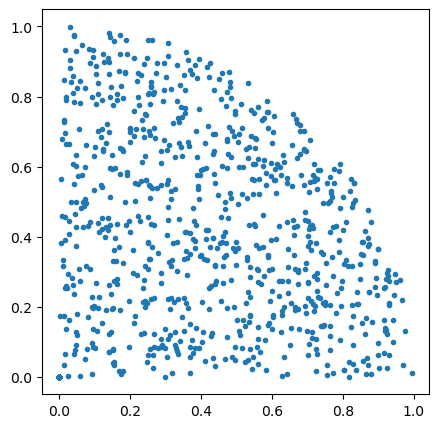

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(outx.get(), outy.get(), marker=".")

None

The problem now is that we're only looking at a quarter of the circle. The `xoroshiro128p_uniform_float32` function generates numbers from $0$ to $1$, but a circle of radius $1$ centered on the origin covers an area that goes from $-1$ to $1$.

We could just use this, calculate $\frac{\pi}{4}$ and then multiply by $4$, but if we use it without recognizing that the area is different, we would get the wrong answer by a factor of $4$.

In [17]:
@nb.cuda.jit
def fill_dots_circle_whole_area(rng_states, outx, outy):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    if x**2 + y**2 < 1:
        outx[thread_idx] = x
        outy[thread_idx] = y

In [18]:
threads_per_block = 1024
blocks_per_grid = 5

rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=12345)

outx = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)
outy = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.float32)

fill_dots_circle_whole_area[blocks_per_grid, threads_per_block](rng_states, outx, outy)

/home/jpivarski/miniforge3/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


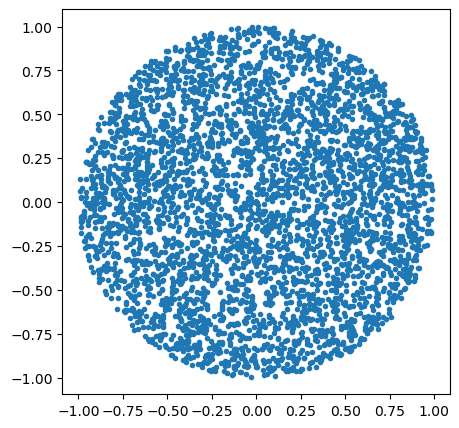

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(outx.get(), outy.get(), marker=".")

None

### Strategy for solving the problem

Now we just have to count how many points fall within the circle. We can do that with `cp.sum` (it's fine to mix Numba and CuPy).

In [20]:
num_selected = cp.sum(outx != 0)
assert num_selected == cp.sum(outy != 0)
num_selected

array(4091)

The number of points that were generated is

In [21]:
num_total = threads_per_block * blocks_per_grid
num_total

5120

So this is the fraction that passed the selection (must be between 0 and 1):

In [22]:
num_selected / num_total

array(0.79902344)

That's also the fraction of area the circle covers, out of the area that was generated.

The area that was generated was $(1 - -1)^2 = 4$ because we stretched both the generated $x$ to $(-1, 1)$ and the generated $y$ to $(-1, 1)$.

So the area that the circle covers is

In [23]:
4 * num_selected / num_total

array(3.19609375)

It's already looking like π. The area of a circle is $A = \pi r^2$ and this radius $r = 1$, so this value _should_ be π.

Now we just want to scale it up and get more precision.

### Choosing the grid size

Since this problem does not have input data, our only constraints on the number of blocks and threads per block are

* we want to fill all of the available processors (more is better),
* each thread must get a distinct random number seed and must have a distinct output to avoid using atomics (fewer is better).

The number of threads per block should saturate each block.

In [24]:
threads_per_block = cp.cuda.Device(0).attributes["MaxThreadsPerBlock"]
threads_per_block

1024

In [25]:
cp.cuda.Device(0).attributes["MultiProcessorCount"]

28

How about

In [26]:
blocks_per_grid = 1024

### Writing a kernel that counts

The previous kernels were intended to display the randomly generated points, so we had each kernel output those values. Our intention now is just to count how many pass the selection, so we can output an integer instead.

We're only interested in the total number, so we might be tempted to make a length-1 array and have each thread increment it. But as we learned earlier in this course, threads updating the same value in parallel can garble it, so it would at least need to be an atomic integer to be valid. Even then, an atomic output would be very slow because every thread would want to increment it at the same time.

Instead, we'll make a `num_in_set` array of integers, with one index position for each thread. We'll add them up later.

In [27]:
@nb.cuda.jit
def count_circle(rng_states, num_in_set):
    thread_idx = nb.cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
    if x**2 + y**2 < 1:
        num_in_set[thread_idx] += 1

rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=12345)

num_in_set = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.int32)

count_circle[blocks_per_grid, threads_per_block](rng_states, num_in_set)

If an $x$, $y$ pair was within the circle, its `num_in_set[thread_idx]` was incremented to 1; otherwise, it was left at its initial value of 0.

Verify that those are the only values in this array (to catch mistakes due to not initializing).

In [28]:
num_in_set.min(), num_in_set.max()

(array(0, dtype=int32), array(1, dtype=int32))

Now apply the same strategy as in the previous section.

In [29]:
num_selected = num_in_set.sum()
num_total = threads_per_block * blocks_per_grid

4 * num_selected / num_total

array(3.14019775)

It's π!

### Scaling up

To run this algorithm on more trials, we _could_ increase the number of blocks.

However, more independent threads would require more random seeds, and it's a waste of resources for each random seed to only be used once. (All of the time would go into generating seeds—just setting up—and not running the algorithm at scale.)

So if we want `num_total_trials > threads_per_block * blocks_per_grid`, how about a `for` loop inside the kernel?

The following solution only works if `num_total_trials` is an integer multiple of `threads_per_block * blocks_per_grid`, but we can accept that in our scale-up plot, rather than make the kernel more complicated.

In [30]:
@nb.cuda.jit
def count_circle_many_times(rng_states, num_trials, num_in_set):
    thread_idx = nb.cuda.grid(1)
    for _ in range(num_trials):
        x = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        y = xoroshiro128p_uniform_float32(rng_states, thread_idx)*2 - 1
        if x**2 + y**2 < 1:
            num_in_set[thread_idx] += 1

def compute_π(num_total_trials, seed):
    num_threads = 1024
    num_blocks = 1024
    num_trials = num_total_trials // (num_threads * num_blocks)
    assert num_trials > 0
    assert num_trials * threads_per_block * blocks_per_grid == num_total_trials

    rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=seed)
    num_in_set = cp.zeros(threads_per_block * blocks_per_grid, dtype=np.int32)

    count_circle_many_times[blocks_per_grid, threads_per_block](rng_states, num_trials, num_in_set)

    return float(4 * num_in_set.sum() / num_total_trials)

In [31]:
compute_π(10 * 1024**2, 12345)

3.1417514801025392

Now let's see how it approaches π as `num_total_trials` increases.

In [32]:
sample_sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
results = []
for n in sample_sizes:
    print(f"{n * 1024**2} trials")
    results.append(compute_π(n * 1024**2, 12345))

1048576 trials
2097152 trials
5242880 trials
10485760 trials
20971520 trials
52428800 trials
104857600 trials
209715200 trials
524288000 trials
1048576000 trials
2097152000 trials
5242880000 trials
10485760000 trials


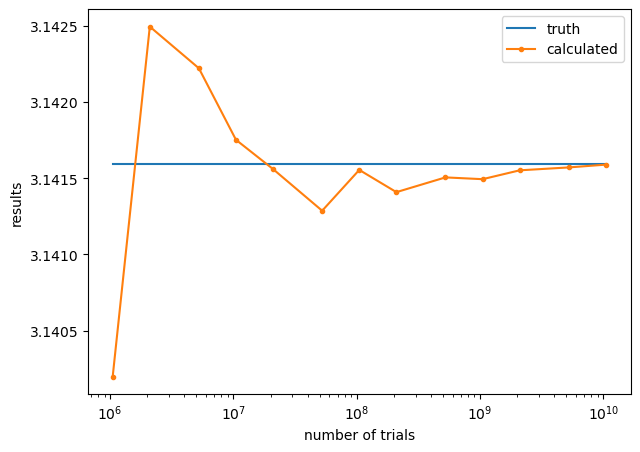

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot([sample_sizes[0] * 1024**2, sample_sizes[-1] * 1024**2], [np.pi, np.pi], label="truth")
ax.plot(np.asarray(sample_sizes) * 1024**2, results, marker=".", label="calculated")

ax.set_xlabel("number of trials")
ax.set_ylabel("results")
ax.set_xscale("log")
ax.legend()

None